# Forecast weather

## Imports

In [23]:
import json

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import requests
from scipy.stats import pearsonr

import tensorflow as tf

from sklearn.metrics import mean_absolute_error

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Send the data back to the business application

In [11]:
def send_message_to_spring_boot(message):
    url = 'http://localhost:9000/ba/api/forecasting'
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, data=json.dumps(message), headers=headers)
    return response.status_code

In [12]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


## Import the CSV file from the previous notebook

In [40]:
data = pd.read_csv('data.csv', delimiter=',', decimal='.', index_col=0)
data.head()

,latitude,longitude,pollution,traffic_level,wind_speed,pressure,temp
timestamp,,,,,,,
2023-09-28T10:10:16.124172,51.034807,4.487884,87.393922,0.00,9.26,990.0,282.51
2023-09-28T10:15:16.124172,51.369962,4.461151,1.889167,0.00,4.12,1029.0,267.63
2023-09-28T10:20:16.124172,51.132341,4.472705,9.878596,0.00,2.57,1009.0,277.37
2023-09-28T10:25:16.124172,51.205491,4.467687,5.735327,158.01,3.60,1014.0,277.10
2023-09-28T10:30:16.124172,51.062829,4.360969,18.838140,0.00,5.66,1002.0,281.42


## Clean up the data

In [41]:
# convert timestamps to datetime to prepare the data for a time series analysis
data.index = pd.to_datetime(data.index, format="%Y-%m-%d %H:%M:%S.%f")

data.index

DatetimeIndex(['2023-09-28 10:10:16.124172', '2023-09-28 10:15:16.124172',
               '2023-09-28 10:20:16.124172', '2023-09-28 10:25:16.124172',
               '2023-09-28 10:30:16.124172', '2023-09-28 10:35:16.124172',
               '2023-09-28 10:40:16.124172', '2023-09-28 10:45:16.124172',
               '2023-09-28 10:50:16.124172', '2023-09-28 10:55:16.124172',
               ...
               '2024-01-12 23:05:16.124172', '2024-01-12 23:10:16.124172',
               '2024-01-12 23:15:16.124172', '2024-01-12 23:20:16.124172',
               '2024-01-12 23:25:16.124172', '2024-01-12 23:30:16.124172',
               '2024-01-12 23:35:16.124172', '2024-01-12 23:40:16.124172',
               '2024-01-12 23:45:16.124172', '2024-01-12 23:50:16.124172'],
              dtype='datetime64[ns]', name='timestamp', length=30693, freq=None)

In [15]:
# Check for missing values
data.isnull().sum()

latitude         0
longitude        0
pollution        0
traffic_level    0
wind_speed       0
pressure         0
temp             0
dtype: int64

In [16]:
# Replace the missing values with the mean
data.fillna(data.mean(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30693 entries, 2023-09-28 10:10:16.124172 to 2024-01-12 23:50:16.124172
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   latitude       30693 non-null  float64
 1   longitude      30693 non-null  float64
 2   pollution      30693 non-null  float64
 3   traffic_level  30693 non-null  float64
 4   wind_speed     30693 non-null  float64
 5   pressure       30693 non-null  float64
 6   temp           30693 non-null  float64
dtypes: float64(7)
memory usage: 1.9 MB


## Correlation analysis

Perform a correlation analysis between the target variable and the other variables to identify significant relationships.

A positive correlation is a relationship between two variables that tend to move in the same direction. A positive correlation exists when one variable tends to decrease as the other variable decreases, or one variable tends to increase when the other increases.

A negative, or inverse correlation, between two variables, indicates that one variable increases while the other decreases, and vice-versa.

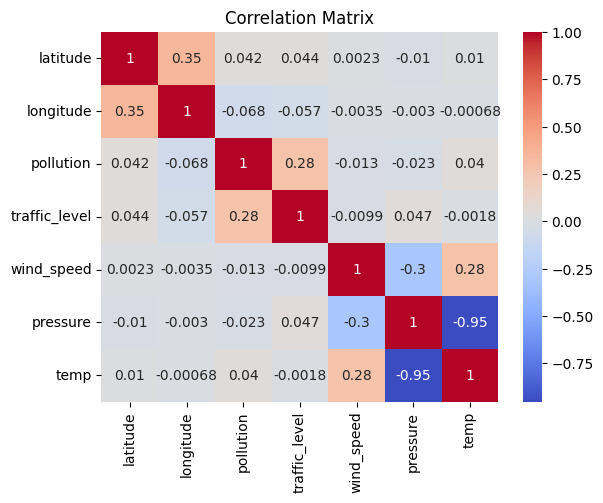

In [18]:
correlations = {}
for column in data.columns:
    if column != 'wind_speed':
        corr, _ = pearsonr(data['wind_speed'], data[column])
        correlations[column] = corr

# Visualizing the Correlations
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Most influential features: pressure and temperature

## Seasonality and trend analysis

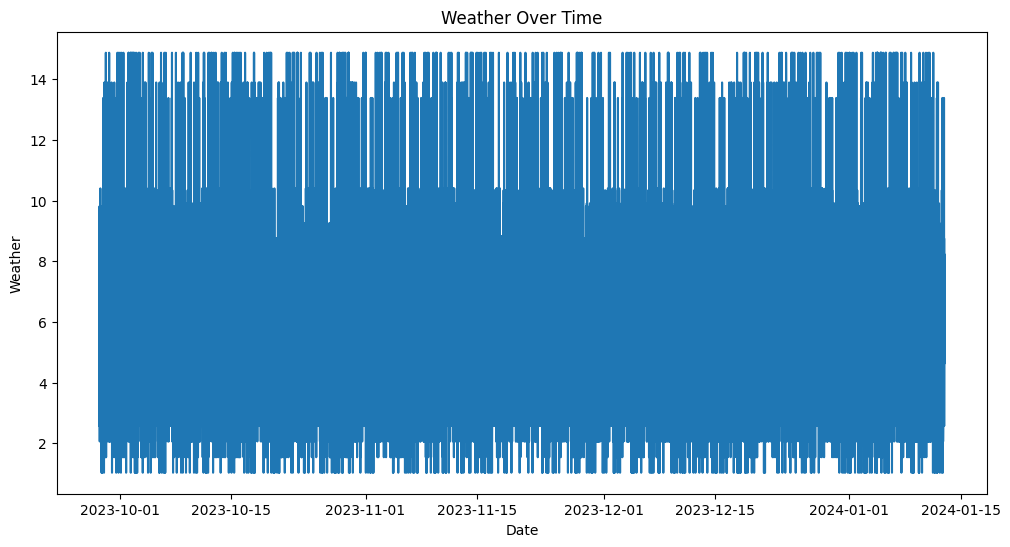

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x=data.index, y='wind_speed')
plt.title('Weather Over Time')
plt.xlabel('Date')
plt.ylabel('Weather')
plt.show()

## Forecast using SARIMAX

The SARIMAX model (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors), is a statistical method used for forecasting times series data. It is an extension of the ARIMA model and is designed to capture complex patterns in time series data.

1. *AR (AutoRegressive)* captures the relationship between an observation and a number of previously. It assumes that the current value of the series can be explained by its previous values.

2. *MA (Moving Average)* models the relationship between an observation and a residual error from a moving average model applied to lagged observations. It helps to smooth out short-term fluctuations and highlight longer-term trends or cycles.

3. *I (Integrated)* subtracts an observation from an observation at a previous time step so that its statistical properties like mean and variance do not change over time.

4. *Seasonal Components* capture seasonality or periodic patterns in the data.

5. *eXogenous Factors* refers to the inclusion of external variables that might affect the time series but are not part of it. These could be variables like weather conditions, economic indicators, etc., that are believed to have an impact on the variable being forecasted.

The SARIMAX model is particularly useful in scenarios where the data shows both non-seasonal and seasonal patterns and where external factors are expected to influence the series. It provides a comprehensive framework for modeling complex behaviors in time series data, making it a popular choice for forecasting in various fields like economics, finance, environmental science, and traffic analysis.

Reasons for choosing the SARIMAX model for our predictions:
*   The data is a times series, it being the primary requirement for SARIMAX.
*   The dataset contains external factors that can influence the weather (temp, pressure etc.) SARIMAX incorporates these as exogenous factors, potentially improving the forecast by accounting for their impact on the patterns.
*   SARIMAX is a flexible model that can handle complex data relationships, including non-stationary data, which is common in real-world time series like weather data.

## Get only the data from the last 24 hours

In [42]:
last_hour_data = data[data.index > data.index.max() - pd.Timedelta(hours=24)]

last_hour_data.head()

,latitude,longitude,pollution,traffic_level,wind_speed,pressure,temp
timestamp,,,,,,,
2024-01-11 23:55:16.124172,51.083513,4.140199,5.435526,326.92,8.23,1030.0,272.31
2024-01-12 00:00:16.124172,51.295956,4.495862,10.140556,191.02,3.09,1035.0,272.85
2024-01-12 00:05:16.124172,51.185571,4.545794,17.909438,334.10,1.03,1034.0,268.07
2024-01-12 00:10:16.124172,51.100063,4.243890,8.620952,617.93,8.75,995.0,280.00
2024-01-12 00:15:16.124172,51.173411,4.447139,7.604375,270.50,6.69,1031.0,272.19


## Select the target variable and the chosed variables for prediction

In [47]:
exog_data = last_hour_data[['pressure', 'temp']]  # exogenous variables
data = last_hour_data['wind_speed']

## Train the model

In [48]:
model = SARIMAX(data, exog=exog_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # the data is hourly and the seasonality is daily
model = model.fit()

# Forecasting the weather for the next hour including exogenous variables
forecast= model.forecast(steps=60, exog=exog_data[-60:])

# Generate forecast index
forecast_index = pd.date_range(start=last_hour_data.index[-1], periods=60, freq='H')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


## Calculate the mean sqaured error

## Plot the prediction

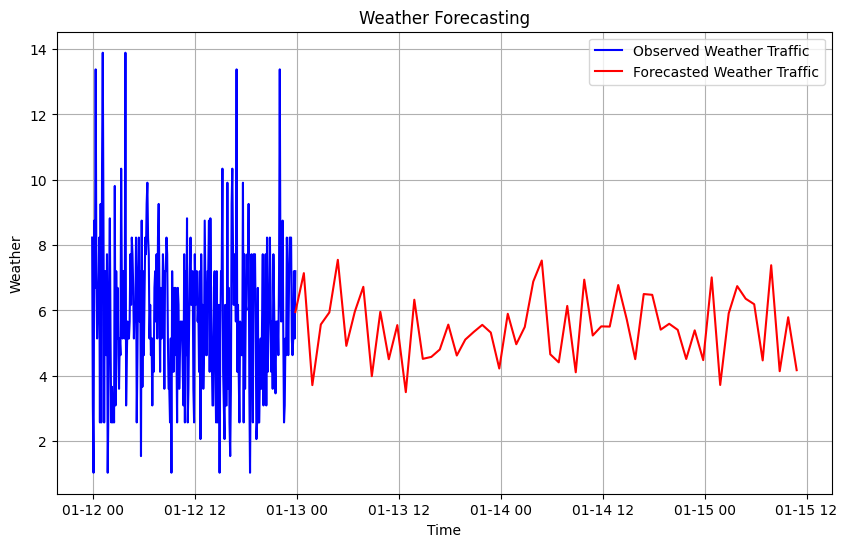

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(last_hour_data['wind_speed'], label='Observed Weather', color='blue')
plt.plot(forecast_index, forecast, label='Forecasted Weather', color='red')
plt.xlabel('Time')
plt.ylabel('Weather')
plt.title('Weather Forecasting')
plt.legend()
plt.grid(True)
plt.show()

## Tranform the predicted values into a JSON file

In [51]:
forecast_data = [{"timestamp": str(index), "wind_speed": float(value)}
                  for index, value in zip(forecast_index, forecast)]

forecast_data

[{'timestamp': '2024-01-12 23:50:16.124172', 'wind_speed': 5.948097875947653},
 {'timestamp': '2024-01-13 00:50:16.124172', 'wind_speed': 7.140635108402684},
 {'timestamp': '2024-01-13 01:50:16.124172', 'wind_speed': 3.711890052078381},
 {'timestamp': '2024-01-13 02:50:16.124172', 'wind_speed': 5.570230543621307},
 {'timestamp': '2024-01-13 03:50:16.124172', 'wind_speed': 5.937927934606002},
 {'timestamp': '2024-01-13 04:50:16.124172', 'wind_speed': 7.54852278560562},
 {'timestamp': '2024-01-13 05:50:16.124172', 'wind_speed': 4.913854927772299},
 {'timestamp': '2024-01-13 06:50:16.124172', 'wind_speed': 5.962761633339369},
 {'timestamp': '2024-01-13 07:50:16.124172', 'wind_speed': 6.722457435474055},
 {'timestamp': '2024-01-13 08:50:16.124172', 'wind_speed': 3.985676863369328},
 {'timestamp': '2024-01-13 09:50:16.124172', 'wind_speed': 5.95626001875285},
 {'timestamp': '2024-01-13 10:50:16.124172', 'wind_speed': 4.50474833511786},
 {'timestamp': '2024-01-13 11:50:16.124172', 'wind_spee

## Send the data to the Business Application

In [39]:
status = send_message_to_spring_boot(forecast_data)
print(f"Response Status: {status}")

ConnectionError: HTTPConnectionPool(host='localhost', port=9000): Max retries exceeded with url: /ba/api/forecasting (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7b9dfb246920>: Failed to establish a new connection: [Errno 111] Connection refused'))